In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report

In [2]:
def show_result(test1):
    # Mostrar los resultados
    fig, ax = plt.subplots(2,1,figsize=(6,3))
    ax[0].plot(test1.history['loss'], color='b', label="Training loss")
    ax[0].plot(test1.history['val_loss'], color='r', label="validation loss")
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].grid()

    ax[1].plot(test1.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(test1.history['val_accuracy'], color='r',label="Validation accuracy")
    ax[1].set_ylim(0,1)
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].grid()

    plt.tight_layout()
    plt.show()

In [3]:
# Cargar los datasets
feat_train = np.load('../0_training_datasets/feat_train.npy')
label_train = np.load('../0_training_datasets/label_train.npy')
feat_val = np.load('../0_training_datasets/feat_val.npy')
label_val = np.load('../0_training_datasets/label_val.npy')


In [4]:
def scale_dataset(mel_list):
    scaler = StandardScaler()

    scaled_mel_list=[]
    for mel in mel_list:
        # primero aplanar para el scaler
        flattened_mel = mel.reshape(-1,1)
        # pasamos por el scaler
        mel_scaled= scaler.fit_transform(flattened_mel)
        # devolvemos la forma original
        flattened_mel=mel_scaled.reshape(mel.shape)
        # Aumentamos la forma para que encaje en como entrada en la red neuronal
        mel_scaled = np.expand_dims(flattened_mel, axis=-1)
        # Almacenamos en la lista
        scaled_mel_list.append(mel_scaled)

    # pasamos a array para la red neuronal
    scaled_mel_array = np.array(scaled_mel_list) 

    return scaled_mel_array

In [5]:
## Estructura 
inputs = layers.Input(shape=(128, 141, 1))

### VGG-13
# Bloque 1
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 2
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 3
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 4
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 5
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Clasificador
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Crear el modelo
VGG13 = models.Model(inputs, outputs, name="VGG13")

# Resumen del modelo
VGG13.summary()


Model: "VGG13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 141, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 141, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 141, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 70, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 70, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 35, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 35, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 17, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 17, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,760,068 (227.97 MB)

 Trainable params: 59,760,068 (227.97 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Define el optimizador y compila el modelo
optimizer = optimizers.Adam(learning_rate=0.0001)
VGG13.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [8]:
# Entrena el modelo
history = VGG13.fit(feat_train, label_train,
                   batch_size=32, epochs=50,
                   validation_data=(feat_val, label_val),
                   verbose=1,
                   callbacks=[early_stopping]
                   )

test_loss, test_acc = VGG13.evaluate(feat_val, label_val, verbose=2)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2703 - loss: 1.4489 - val_accuracy: 0.2754 - val_loss: 1.3606
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.2670 - loss: 1.3562 - val_accuracy: 0.6377 - val_loss: 1.0599
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5065 - loss: 1.0652 - val_accuracy: 0.6812 - val_loss: 0.9251
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7622 - loss: 0.7216 - val_accuracy: 0.6957 - val_loss: 0.5739
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8484 - loss: 0.4121 - val_accuracy: 0.7826 - val_loss: 0.4940
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8465 - loss: 0.3878 - val_accuracy: 0.8551 - val_loss: 0.3932
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9005 - loss: 0.2929 - val_accuracy: 0.8406 - val_loss: 0.4177
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9047 - loss: 0.2493 - val_accuracy: 0.8406 - val_loss:

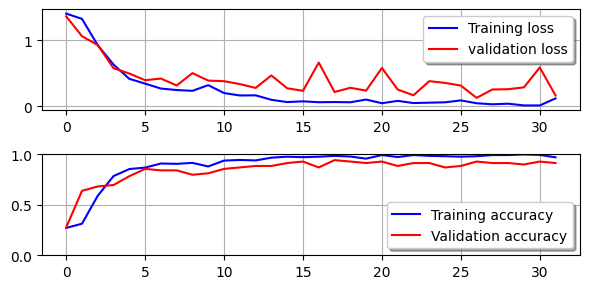

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
              precision    recall  f1-score   support

     Paisaje       1.00      0.92      0.96        13
       Avion       0.90      1.00      0.95        19
       Motor       0.93      0.82      0.88        17
       Voces       0.90      0.95      0.93        20

    accuracy                           0.93        69
   macro avg       0.94      0.92      0.93        69
weighted avg       0.93      0.93      0.93        69



In [9]:
show_result(history)
# Haz predicciones en el conjunto de validación
y_pred = VGG13.predict(feat_val)

# Convierte las predicciones a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(label_val, axis=1)

# Calcula precision, recall, y F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=['Paisaje', 'Avion', 'Motor', 'Voces'])
print(report)

In [35]:
# VGG13.save("VGG13_c.keras")